In [1]:
import math
from pathlib import Path

import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skimage
from ipywidgets import fixed, interact
from scipy import fft
from scipy import ndimage as ndi
from scipy import signal
from scipy.cluster.vq import kmeans2
from scipy.signal import convolve2d as conv2
from skimage import color, data, draw
from skimage import exposure as exp
from skimage import feature as feat
from skimage import filters, graph, img_as_float, io, measure
from skimage import morphology as morph
from skimage import restoration as rest
from skimage import segmentation as seg
from skimage import transform as trans
from skimage import util
from skimage.filters import rank, thresholding
from skimage.morphology import disk, square

In [2]:
IMAGE_DIR = Path(".") / "data" / "images"

matplotlib.rcParams.update({"font.size": 11})

In [3]:
suffixes = (".jpeg", ".png")

PATHS = [p for p in IMAGE_DIR.glob("*.*") if p.suffix in suffixes]
path = PATHS[0]

In [4]:
def rescale(img):
    p2, p98 = np.percentile(img, (2, 98))
    rescaled = exp.rescale_intensity(img, in_range=(p2, p98))
    return rescaled

(dtype('uint8'), 18, 254)

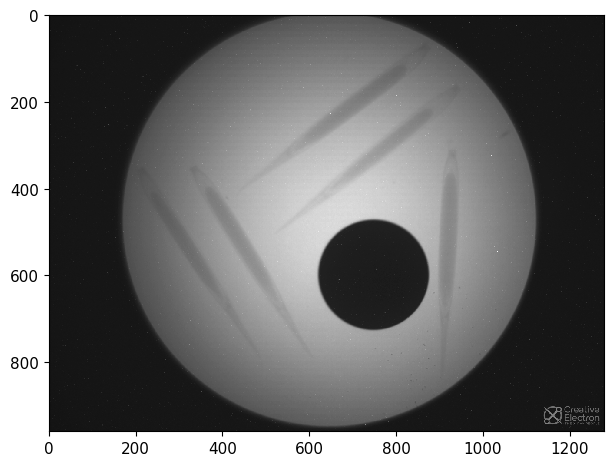

In [5]:
orig = io.imread(path)
gray = np.uint8(color.rgb2gray(orig) * 255.0)
io.imshow(gray)
gray.dtype, gray.min(), gray.max()

(dtype('bool'), False, True)

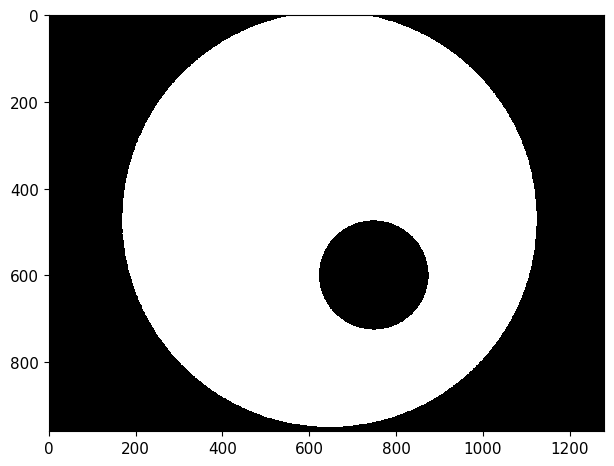

In [6]:
mask = 48 < gray
io.imshow(mask)

mask = morph.binary_erosion(mask)

rr, cc = draw.rectangle((750, 1100), mask.shape, shape=mask.shape)
mask[rr, cc] = 0

io.imshow(mask)
mask.dtype, mask.min(), mask.max()

In [7]:
def auto_level_search(image, footprint_disk=50, low=0.2, high=0.8):
    footprint = disk(footprint_disk)

    autolevel = filters.rank.autolevel_percentile(
        image, footprint=footprint, p0=low, p1=high, mask=mask
    )

    image_list = {
        "original": image,
        "auto_level%": autolevel,
    }

    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(10, 10), sharex=True, sharey=True
    )
    ax = axes.ravel()

    for i, (title, img) in enumerate(image_list.items()):
        ax[i].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=255)
        ax[i].set_title(title)
        ax[i].axis("off")
    plt.tight_layout()

    return autolevel


interact(
    auto_level_search,
    image=fixed(gray),
    footprint_disk=(0, 100),
    low=(0.0, 1.0, 0.01),
    high=(0.0, 1.0, 0.01),
)

interactive(children=(IntSlider(value=50, description='footprint_disk'), FloatSlider(value=0.2, description='l…

<function __main__.auto_level_search(image, footprint_disk=50, low=0.2, high=0.8)>

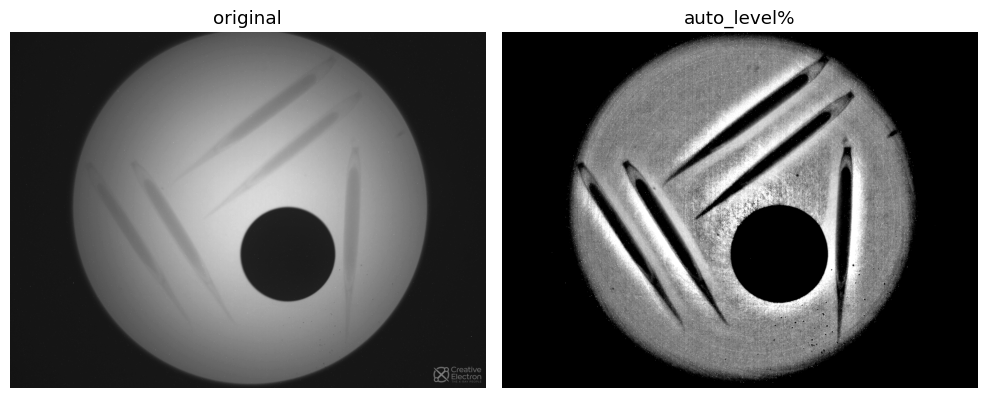

In [8]:
autolevel = auto_level_search(gray, 50, 0.2, 0.8)

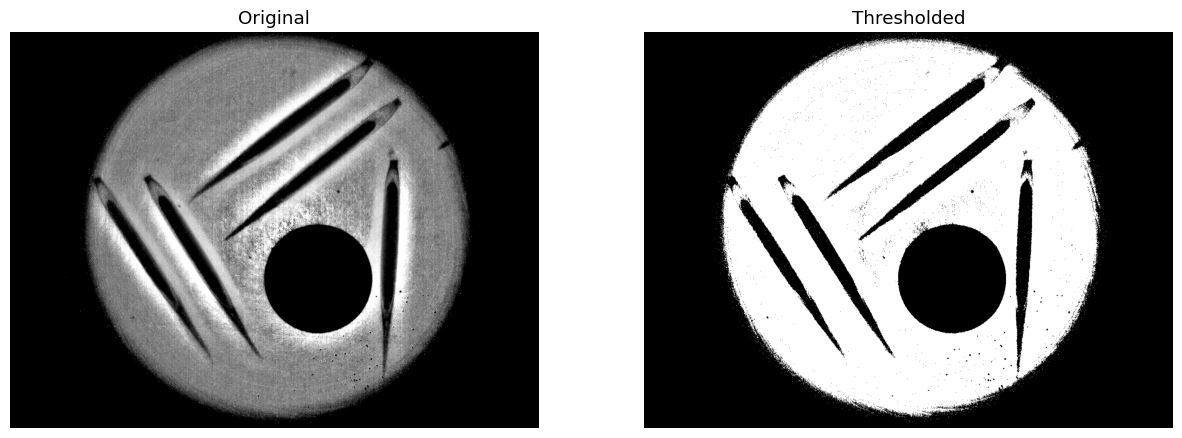

In [9]:
def otsu_threshold(image):
    thresh = filters.threshold_otsu(image)
    binary = image > thresh
    binary = binary & mask

    fig, axes = plt.subplots(ncols=2, figsize=(15, 10))
    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(binary, cmap=plt.cm.gray)
    ax[1].set_title("Thresholded")
    ax[1].axis("off")

    plt.show()
    return binary


thresh1 = otsu_threshold(autolevel)

In [10]:
def unsharp_mask(image, radius=1, amount=1):
    result_1 = filters.unsharp_mask(image, radius=radius, amount=amount)

    fig, axes = plt.subplots(
        nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10, 10)
    )
    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title("original image")
    ax[1].imshow(result_1, cmap=plt.cm.gray)
    ax[1].set_title("unsharp image")

    for a in ax:
        a.axis("off")
    fig.tight_layout()
    plt.show()
    return result_1


interact(
    unsharp_mask,
    image=fixed(autolevel),
    radius=(0, 100),
    amount=(-10.0, 10.0),
)

interactive(children=(IntSlider(value=1, description='radius'), FloatSlider(value=1.0, description='amount', m…

<function __main__.unsharp_mask(image, radius=1, amount=1)>

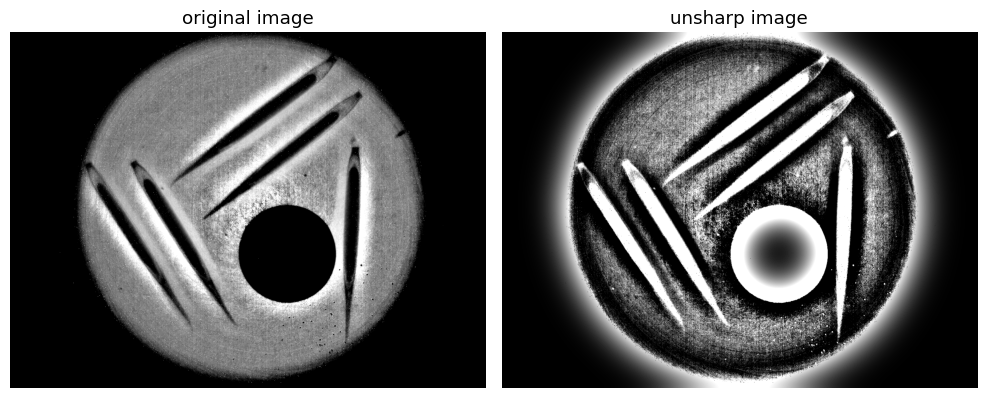

In [11]:
unsharp = unsharp_mask(autolevel, 50, -4.5)

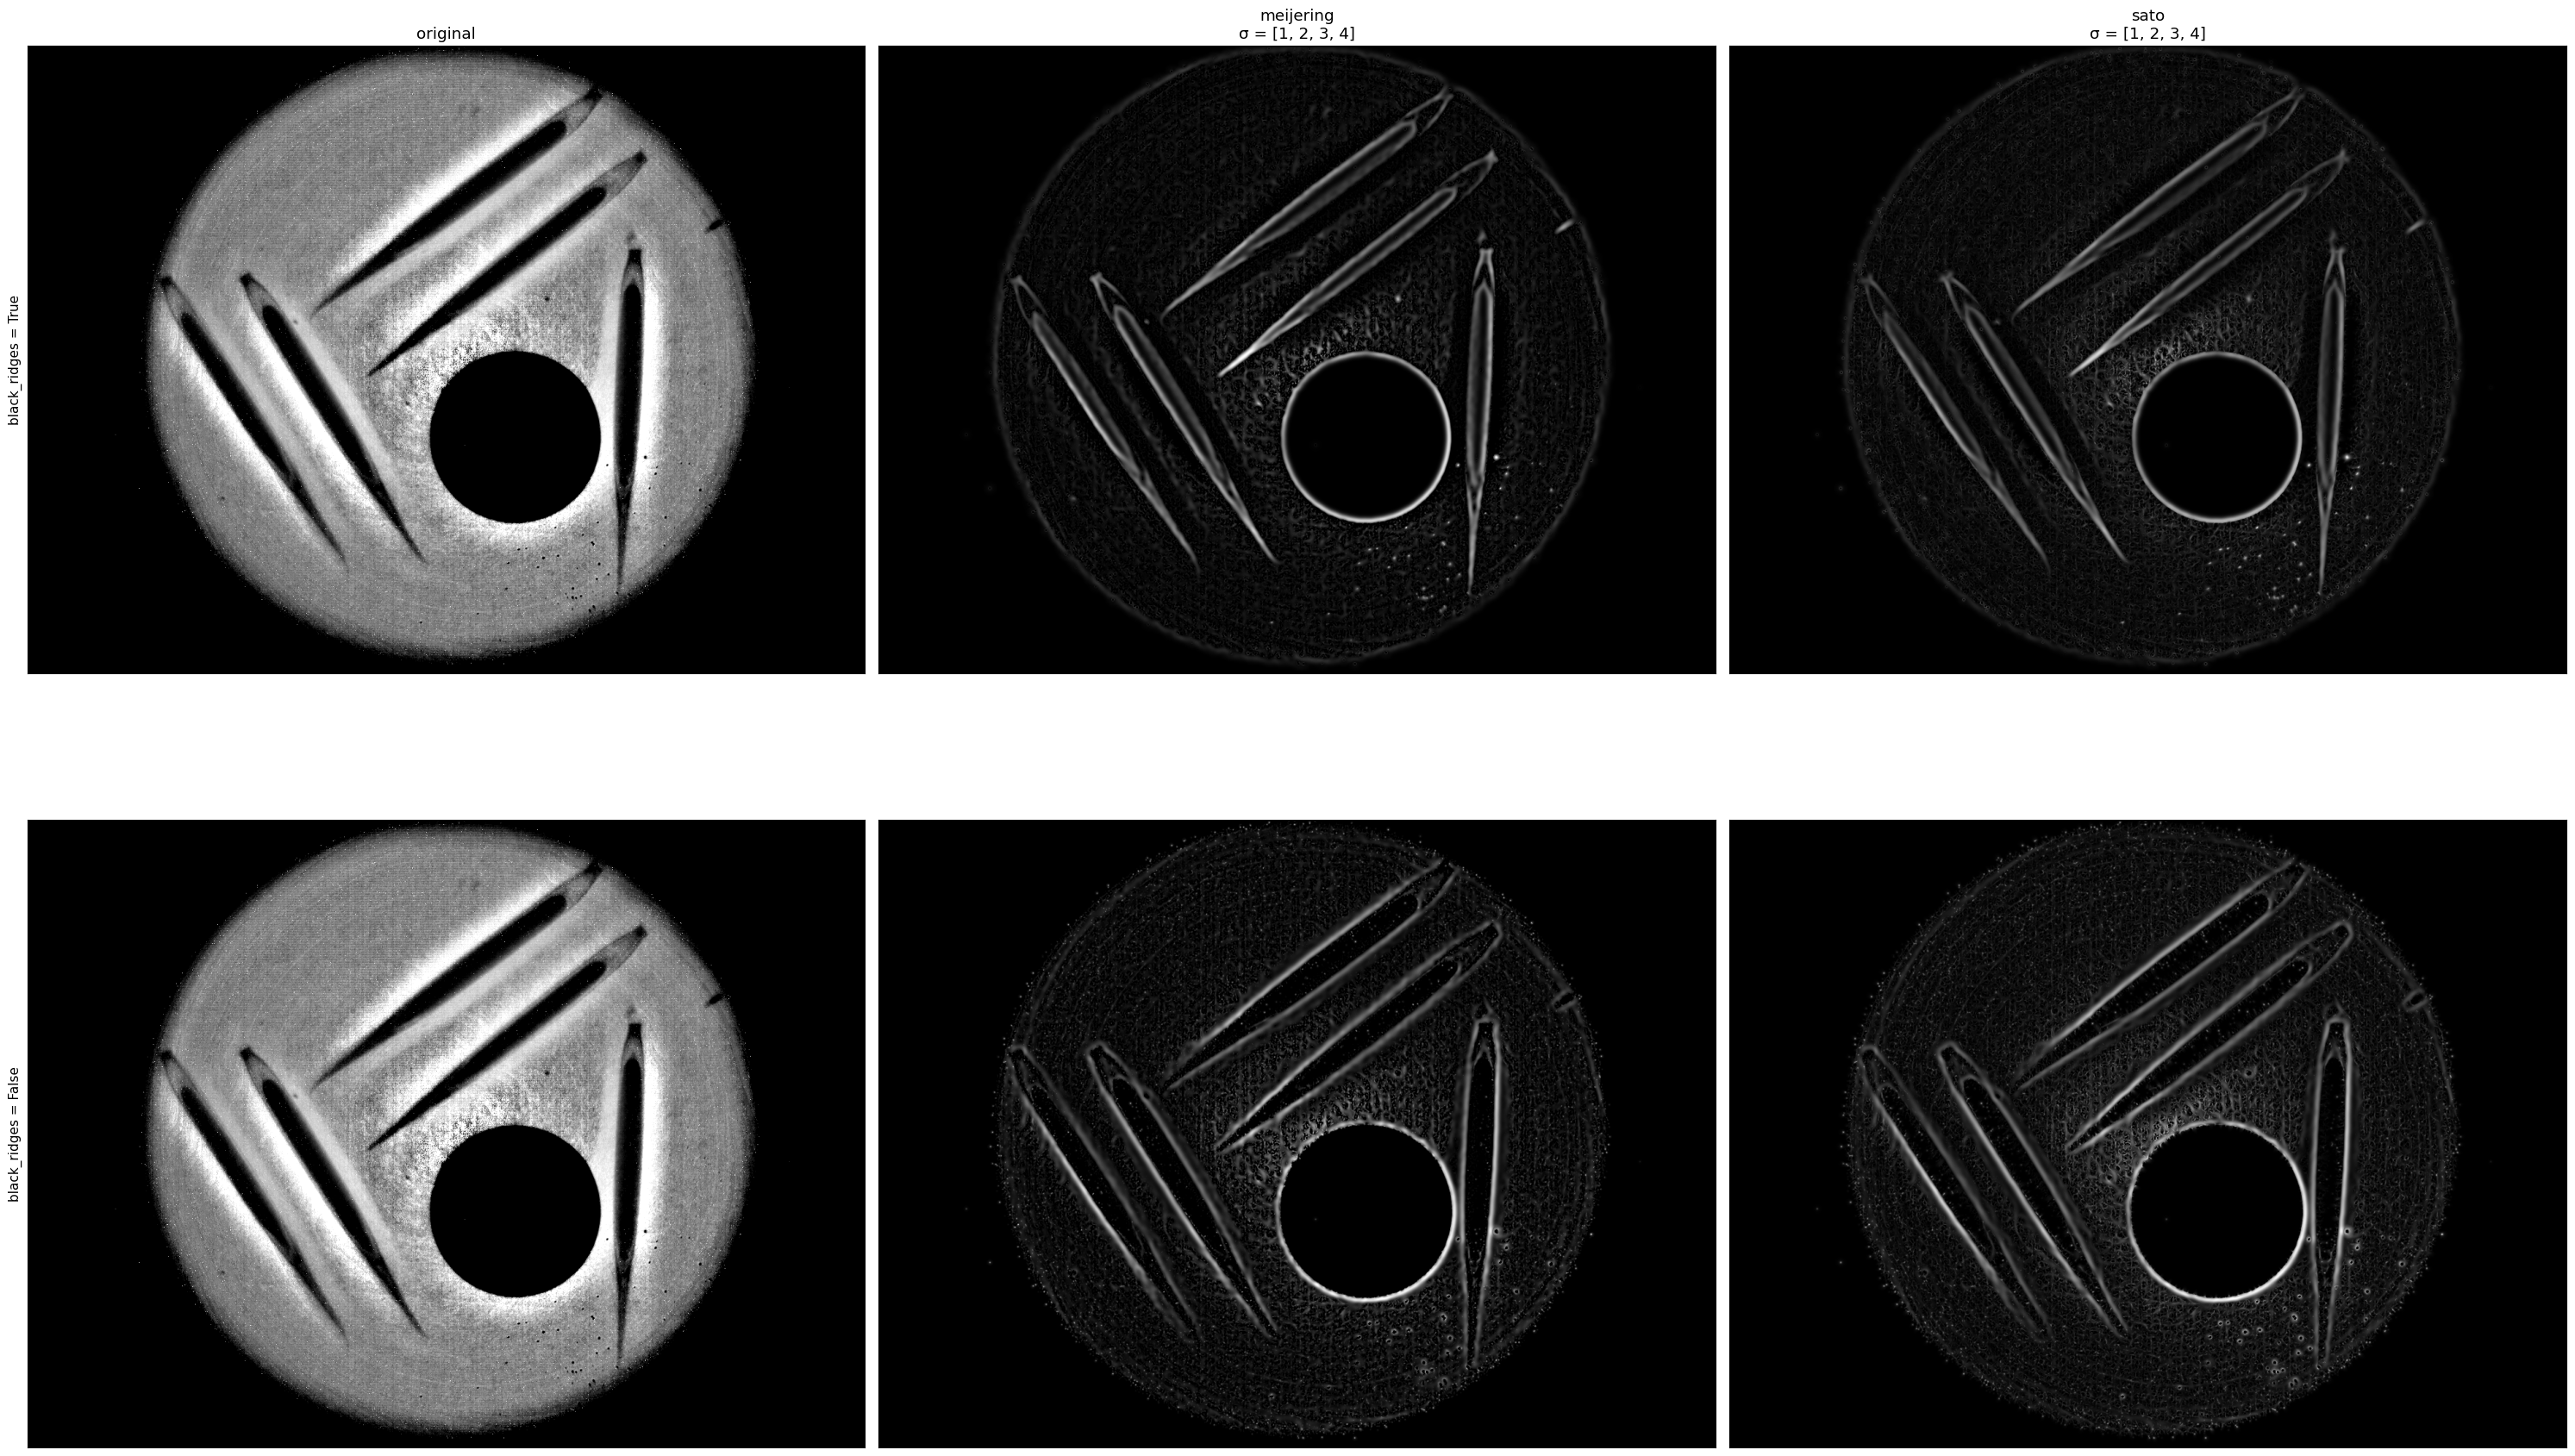

In [12]:
def original(image, **kwargs):
    """Return the original image, ignoring any kwargs."""
    return image


def ridge_filters(image):
    cmap = plt.cm.gray

    plt.rcParams["axes.titlesize"] = "large"
    axes = plt.figure(figsize=(30, 20)).subplots(2, 3)
    for i, black_ridges in enumerate([True, False]):
        for j, (func, sigmas) in enumerate(
            [
                (original, None),
                (filters.meijering, range(1, 5)),
                (filters.sato, range(1, 5)),
            ]
        ):
            result = func(image, black_ridges=black_ridges, sigmas=sigmas)
            axes[i, j].imshow(result, cmap=cmap)
            if i == 0:
                title = func.__name__
                if sigmas:
                    title += f"\n\N{GREEK SMALL LETTER SIGMA} = {list(sigmas)}"
                axes[i, j].set_title(title)
            if j == 0:
                axes[i, j].set_ylabel(f"{black_ridges = }")
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

    plt.tight_layout()
    plt.show()


ridge_filters(autolevel)

In [13]:
ridges = filters.meijering(autolevel, black_ridges=True, sigmas=(1, 2, 3, 4))

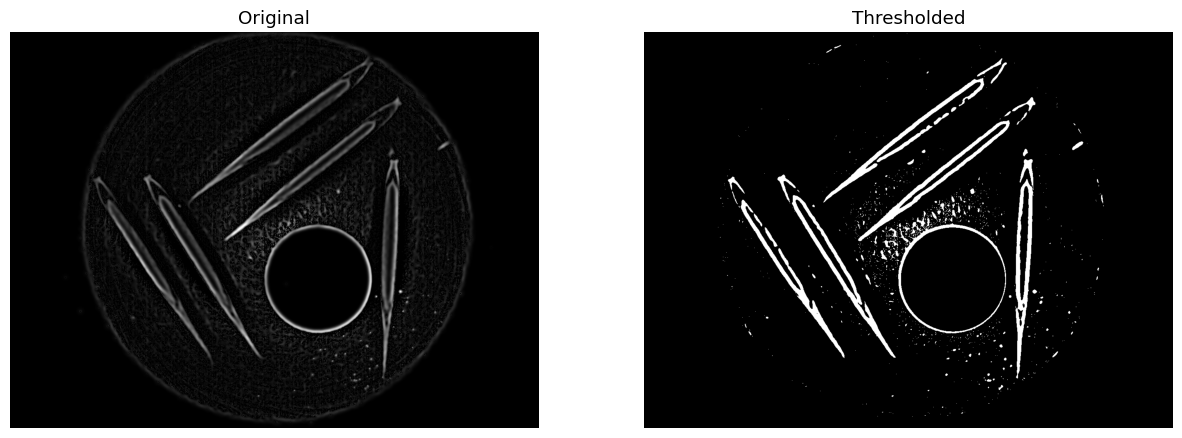

In [14]:
threshold2 = otsu_threshold(ridges)

In [15]:
def find_edges(image, mean_disk=0, min_disk=0, max_disk=0, sigma=1):
    image_list = {"input image": image}

    mean1, min1 = None, None

    chain = image.copy()

    if mean_disk > 0:
        mean1 = rank.mean(chain, disk(mean_disk))
        # mean1 = rescale(mean1)
        image_list["mean"] = mean1
        chain = mean1

    if min_disk > 0:
        min1 = rank.minimum(chain, disk(min_disk))
        # min1 = rescale(min1)
        image_list["min"] = min1
        chain = min1

    if max_disk > 0:
        max1 = rank.minimum(chain, disk(max_disk))
        # max1 = rescale(max1)
        image_list["max"] = max1
        chain = max1

    if sigma > 0:
        edges = np.uint8(feat.canny(chain, sigma=sigma) * 255.0)
        image_list["edges"] = edges
        chain = edges

    nrows = 2 if len(image_list) > 3 else 1
    ncols = 3 if len(image_list) > 2 else len(image_list) % 3

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(15, 10), sharex=True, sharey=True
    )
    ax = axes.ravel()

    for i, (title, img) in enumerate(image_list.items()):
        ax[i].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=255)
        ax[i].set_title(title)
        ax[i].axis("off")
    plt.tight_layout()

    return chain


interact(
    find_edges,
    image=fixed(util.img_as_ubyte(ridges)),
    mean_disk=(0, 100),
    min_disk=(0, 100),
    max_disk=(0, 100),
    sigma=(0.0, 10.0),
)

interactive(children=(IntSlider(value=0, description='mean_disk'), IntSlider(value=0, description='min_disk'),…

<function __main__.find_edges(image, mean_disk=0, min_disk=0, max_disk=0, sigma=1)>

(dtype('uint8'), (960, 1280))

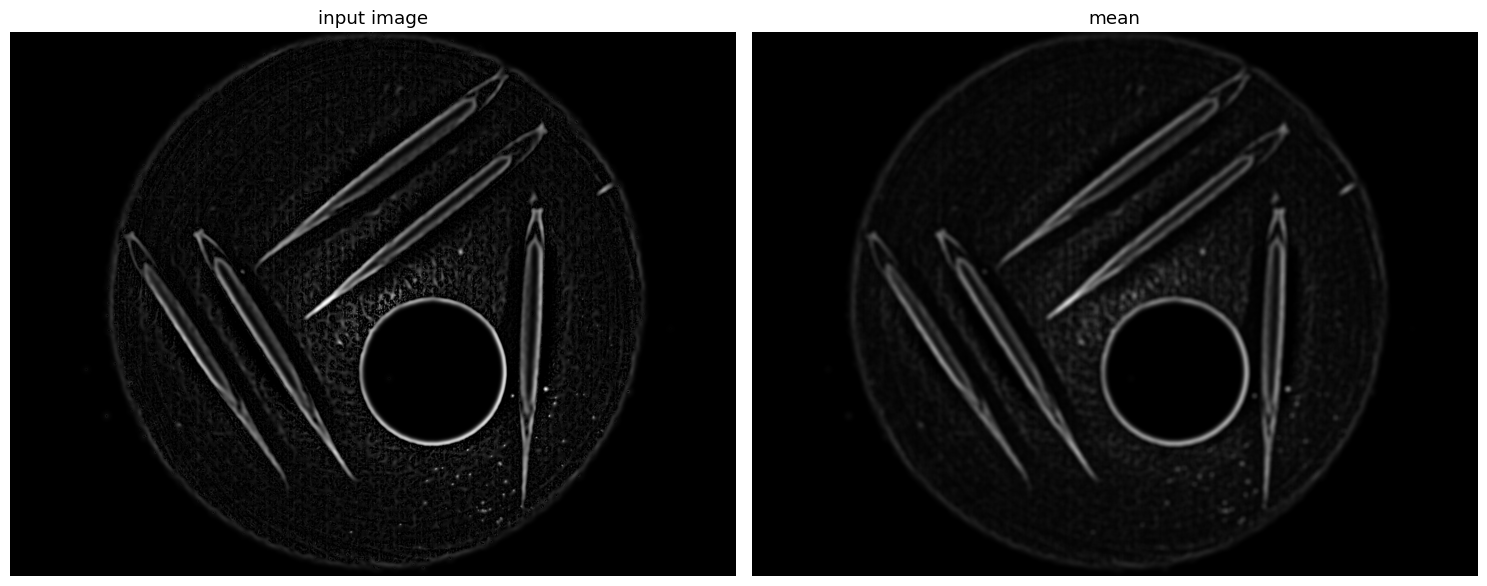

In [16]:
# edges = find_edges(util.img_as_ubyte(ridges), mean_disk=5, sigma=0.9)
blur = find_edges(util.img_as_ubyte(ridges), mean_disk=5, sigma=0.0)
blur.dtype, blur.shape

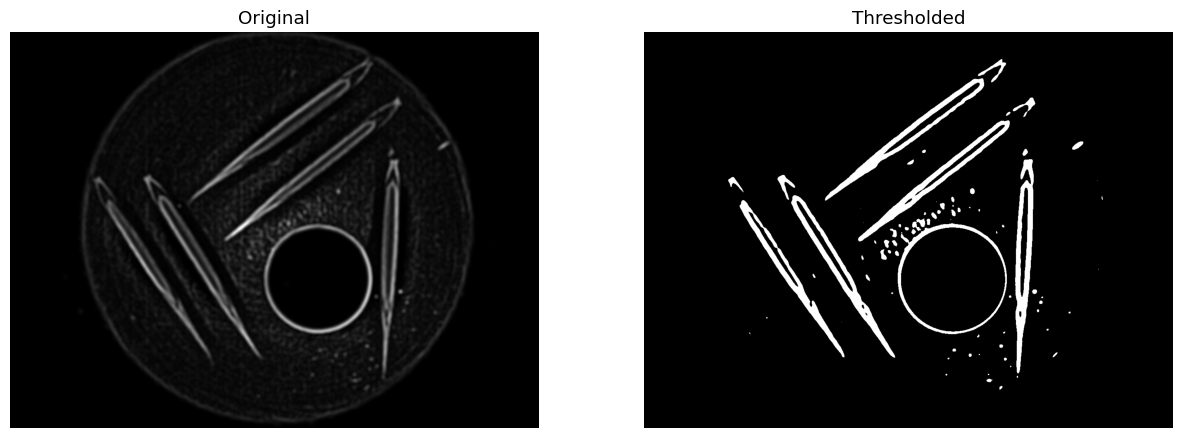

In [17]:
threshold3 = otsu_threshold(blur)

In [18]:
def remove_stuff(image, min_size=0, area_threshold=0):
    chain = image.copy()

    if min_size > 0:
        chain = morph.remove_small_objects(chain, min_size=min_size)

    if area_threshold > 0:
        chain = morph.remove_small_holes(chain, area_threshold=area_threshold)

    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(15, 10), sharex=True, sharey=True
    )
    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title("original")
    ax[0].axis("off")

    ax[1].imshow(chain, cmap=plt.cm.gray)
    ax[1].set_title("removed")
    ax[1].axis("off")

    plt.tight_layout()
    return chain

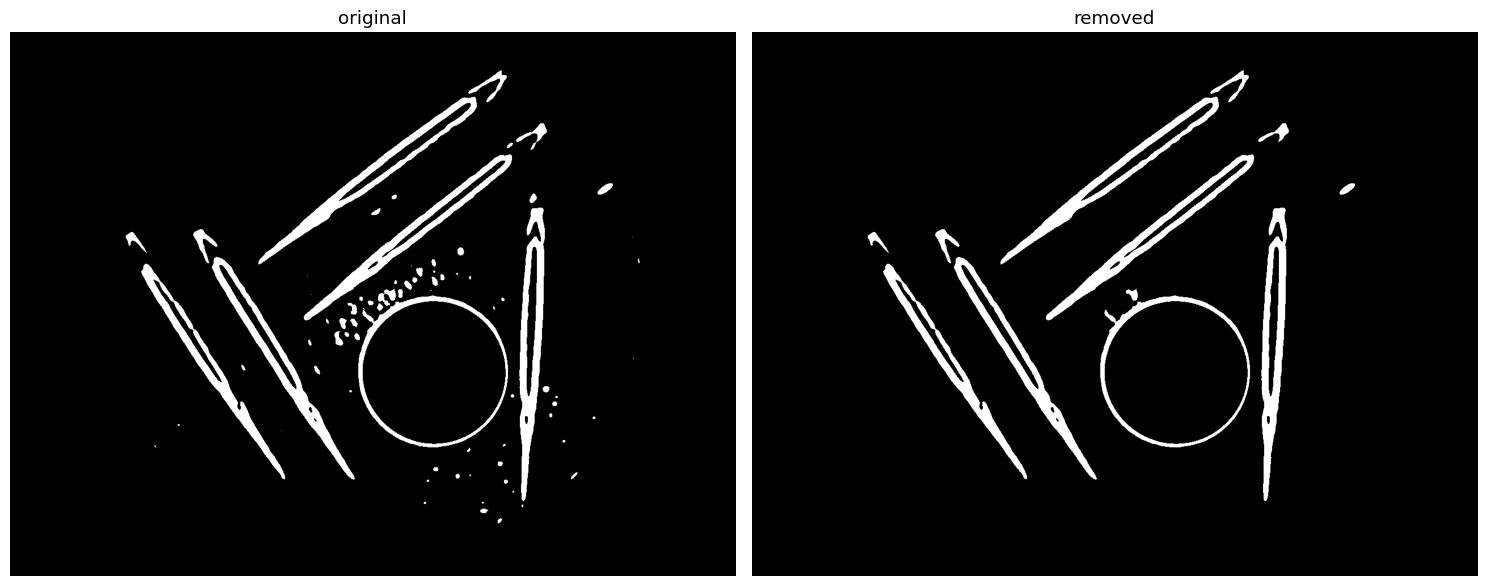

In [19]:
def speckles(image, footprint=None):
    chain = image.copy()

    chain = morph.binary_dilation(chain, footprint=footprint)

    # if area_threshold > 0:
    #     chain = morph.remove_small_holes(chain, area_threshold=area_threshold)

    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(15, 10), sharex=True, sharey=True
    )
    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title("original")
    ax[0].axis("off")

    ax[1].imshow(chain, cmap=plt.cm.gray)
    ax[1].set_title("modified")
    ax[1].axis("off")

    plt.tight_layout()
    return chain


modified = remove_stuff(threshold3, min_size=256)
# modified = speckles(modified, disk(3))
# modified = remove_stuff(modified, min_size=512)
# modified = speckles(modified, disk(5))
# modified = remove_stuff(modified, min_size=1024)

In [20]:
# image = modified
# coords = feat.corner_peaks(feat.corner_harris(image), min_distance=5, threshold_rel=0.02)
# coords_subpix = feat.corner_subpix(image, coords, window_size=13)

# fig, ax = plt.subplots()
# ax.imshow(image, cmap=plt.cm.gray)
# ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
#         linestyle='None', markersize=6)
# ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
# ax.axis((0, 310, 200, 0))
# plt.show()

In [21]:
# def remove_circles(image, edges, small=75, large=500, count=4):
#     # Detect two radii
#     hough_radii = np.arange(small, large, 4)
#     hough_res = trans.hough_circle(edges, hough_radii)

#     # Select the most prominent 2 circles
#     accums, cx, cy, radii = trans.hough_circle_peaks(
#         hough_res, hough_radii, total_num_peaks=count
#     )

#     fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))

#     # Try to remove the circles

#     image = color.gray2rgb(image)
#     for center_y, center_x, radius in zip(cy, cx, radii):
#         circy, circx = draw.circle_perimeter(
#             center_y, center_x, radius, shape=image.shape
#         )
#         image[circy, circx] = (220, 20, 20)

#     ax.imshow(image, cmap=plt.cm.gray)
#     plt.show()

#     return image

# no_circles = remove_circles(autolevel, binary, count=2)